<a href="https://colab.research.google.com/github/Nanfemicit/EOS-Course/blob/main/Copy_of_Extreme_precipitation_CHELSA_excersise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrem value analysis Tenerife precipitation

This script analyzes **spatial and temporal precipitation data** using **daily precipitation records**, focusing on **extreme value events**.

In [1]:
#Install some libaries first!
!pip install xclim
!pip install lmoments3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.2 MB/s eta 0:00:00


In [2]:
#Import need libaries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import lmoments3
from lmoments3 import distr

from xclim.core.missing import missing_pct
from xclim.indices.generic import select_resample_op
from xclim.indices.stats import fa, fit, frequency_analysis, parametric_quantile
import gdown

#Download data

We utilize precipitation data from [CHELSA](https://chelsa-climate.org/), a high-resolution climate dataset derived from downscaled ERA5 reanalysis data. A preprocessed dataset is available for download from Google Drive:

In [3]:
# Download CHELSA precipitation data from Google Drive
#'GOOGLE_DRIVE_LINK' to NetCDF file
url = 'https://drive.google.com/file/d/1Z9-YDydbsxFBq4Do43KaB3-Lyzm9dkpd/view?usp=drive_link'
# Download the NetCDF file
file_path = 'CHELSA_precipitation.nc'
gdown.download(url, file_path, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1Z9-YDydbsxFBq4Do43KaB3-Lyzm9dkpd
From (redirected): https://drive.google.com/uc?id=1Z9-YDydbsxFBq4Do43KaB3-Lyzm9dkpd&confirm=t&uuid=42d4ed6d-cc16-4500-8717-1932b0a713dc
To: /content/CHELSA_precipitation.nc
100%|██████████| 325M/325M [00:03<00:00, 106MB/s]


'CHELSA_precipitation.nc'

#Load data

Since this dataset contains spatial and temporal data, forming a 3D data cube, we will use [XArray](https://docs.xarray.dev/en/stable/), a specialized data protocol designed for handling multi-dimensional scientific data efficiently. To begin, we will open the NetCDF file using XArray:

In [4]:
#Load precipitation data as XArray
daily_precipitation = xr.open_dataset(file_path)
daily_precipitation

<xarray.Dataset> Size: 325MB
Dimensions:  (time: 5114, lat: 77, lon: 103)
Coordinates:
  * time     (time) datetime64[ns] 41kB 2003-01-01 2003-01-02 ... 2016-12-31
  * lat      (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon      (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
Data variables:
    tp       (time, lat, lon) float64 324MB ...
Attributes:
    units:    mm/d

In [5]:
# create a array which only conains the years - we need this later
years = daily_precipitation['time'].dt.year.values

#Generate precipitation maps

Next, we will generate, plot, and save maps displaying the mean total annual precipitation and the mean annual variance of precipitation over the given time period.

In [6]:
# Calcualte mean total annual precipitation
# first group by year and sum up values
annual_total_precipitation = daily_precipitation.groupby('time.year').sum(dim='time')
# second calaculate the mean
annual_total_precipitation_mean = annual_total_precipitation.mean(dim='year')

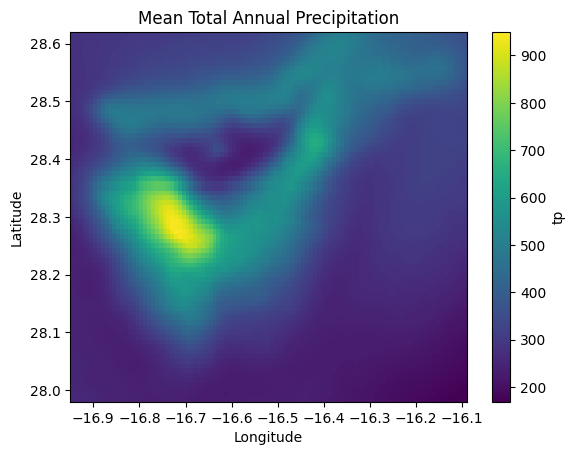

In [7]:
# Plot the map of mean total annual precipitation
annual_total_precipitation_mean['tp'].plot.imshow()
plt.title('Mean Total Annual Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
# Calcualte mean annual variance of precipitation
annual_var_precipitation = daily_precipitation.groupby('time.year').var(dim='time')
annual_var_precipitation_mean = annual_var_precipitation.mean(dim='year')

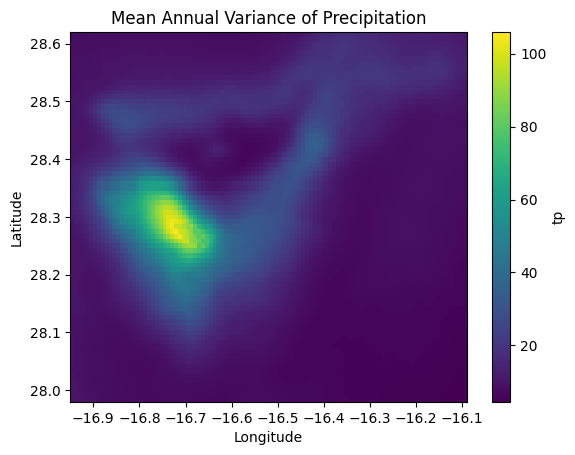

In [9]:
# Plot the map of mean annual variance precipitation
annual_var_precipitation_mean['tp'].plot.imshow()
plt.title('Mean Annual Variance of Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
# Store the mean and variance maps as netcdf file
filename = 'CHELSA_Tenerife_mean_total_precipitation_'  + str(years[0]) + '_' + str(years[-1]) + '.nc'
annual_total_precipitation_mean.to_netcdf(filename)
filename = 'CHELSA_Tenerife_mean_variance_precipitation_'  + str(years[0]) + '_' + str(years[-1]) + '.nc'
annual_var_precipitation_mean.to_netcdf(filename)

# **Extreme Value Analysis**

In this section, we will perform an **Extreme Value Analysis (EVA)** to assess extreme precipitation events. The following steps will be carried out:

- **Calculate the block maxima** with an **annual frequency** for each pixel.
- **Fit the Generalized Extreme Value (GEV) distribution** to these maxima for each pixel. *(Note: Depending on the selected method, this step may take some time to compute.)*
- **Estimate extreme precipitation events** corresponding to **5-, 15-, 25-, and 50-year return periods**.
- **Generate complete maps** of expected extreme precipitation events using **QGIS**, incorporating the **Tenerife Shapefile** for spatial context.

To accomplish this, we will utilize the [**xclim library**](https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html), which is already imported in the script header. This library provides specialized tools for climate indices and frequency analysis, facilitating our calculations.

In [34]:
# Use the libary xclim (https://xclim.readthedocs.io/en/stable/notebooks/frequency_analysis.html)
# to optain the Block Maxima with yearly frequency
# Resample daily precipitation to yearly maxima using xarray
# Compute annual maximum precipitation using xarray resampling
annual_max_precip = sub.resample(time="YS").max()

# Print to verify the computed values
print(annual_max_precip)



<xarray.Dataset> Size: 890kB
Dimensions:  (time: 14, lat: 77, lon: 103)
Coordinates:
  * lat      (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon      (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * time     (time) datetime64[ns] 112B 2003-01-01 2004-01-01 ... 2016-01-01
Data variables:
    tp       (time, lat, lon) float64 888kB 24.46 25.08 25.55 ... 6.38 6.39 6.5
Attributes:
    units:    mm/d


In [36]:
# We use the xclim libary to fit GEV function (dist=dist.gev)
# Therefore, we can select from a broad range of fitting methods:
# - Maximum Likelihood algorithm (method="ML") - Default but very sensetive to outliers
# - Method of Moments (method="MM") - not working with our data
# - Maximum Likelihood Estimation (method="MLE") - kind of similar but diffrent to ML
# - Probability Weighted Moments (method="PWM") - More robust to oulierts!
# PWM is well suited for small samples which in our case make it the prefered method.

# Fit the Generalized Extreme Value (GEV) distribution using PWM method
gev_params = fit(annual_max_precip, dist=distr.gev, method="PWM")

print(gev_params)


<xarray.Dataset> Size: 192kB
Dimensions:  (lat: 77, lon: 103, dparams: 3)
Coordinates:
  * lat      (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon      (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * dparams  (dparams) <U5 60B 'c' 'loc' 'scale'
Data variables:
    tp       (dparams, lat, lon) float64 190kB 0.03036 0.01005 ... 11.91 11.81
Attributes:
    original_units:  mm/d
    long_name:       genextreme parameters
    description:     Parameters of the genextreme distribution
    method:          PWM
    estimator:       Probability weighted moments
    scipy_dist:      genextreme
    units:           
    history:         [2025-02-05 18:37:15] fit: Estimate distribution paramet...


In [40]:
# We use the xclim libary to extract the quantile value for a given return period
# as input we need:
# - the previously fitted parameters (params) of the distribution function
# - the quatinetile we are interested in which relates to the probability of excedance (q = 1-P = 1-1/tau)

# Define return periods (tau)
return_periods = [5, 15, 25, 50]

# Convert return periods to quantile probabilities (q = 1 - 1/tau)
q_values = [1 - 1/tau for tau in return_periods]

# Compute quantile values using the fitted GEV parameters
quantiles = parametric_quantile(gev_params, q_values)
quantiles



<xarray.Dataset> Size: 255kB
Dimensions:   (lat: 77, lon: 103, quantile: 4)
Coordinates:
  * lat       (lat) float64 616B 28.62 28.61 28.6 28.59 ... 28.0 27.99 27.98
  * lon       (lon) float64 824B -16.95 -16.94 -16.93 ... -16.11 -16.1 -16.09
  * quantile  (quantile) float64 32B 0.8 0.9333 0.96 0.98
Data variables:
    tp        (lat, lon, quantile) float64 254kB 39.65 51.37 ... 51.32 56.53
Attributes:
    units:         mm/d
    long_name:     genextreme quantiles
    description:   Quantiles estimated by the genextreme distribution
    method:        PWM
    estimator:     Probability weighted moments
    scipy_dist:    genextreme
    history:       [2025-02-05 18:37:15] fit: Estimate distribution parameter...
    cell_methods:  dparams: ppf

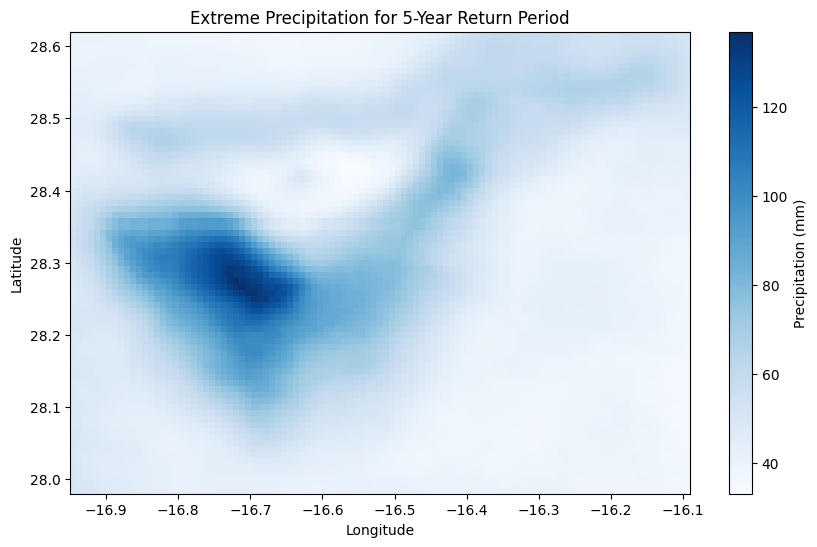

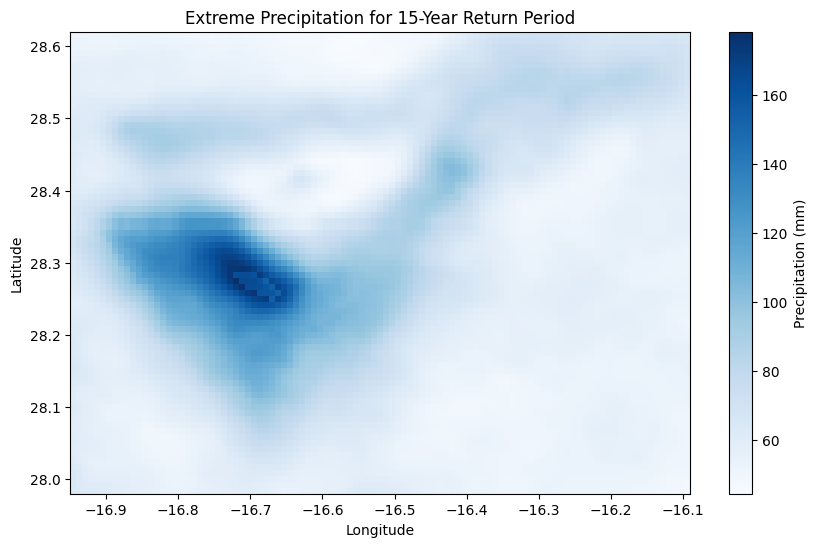

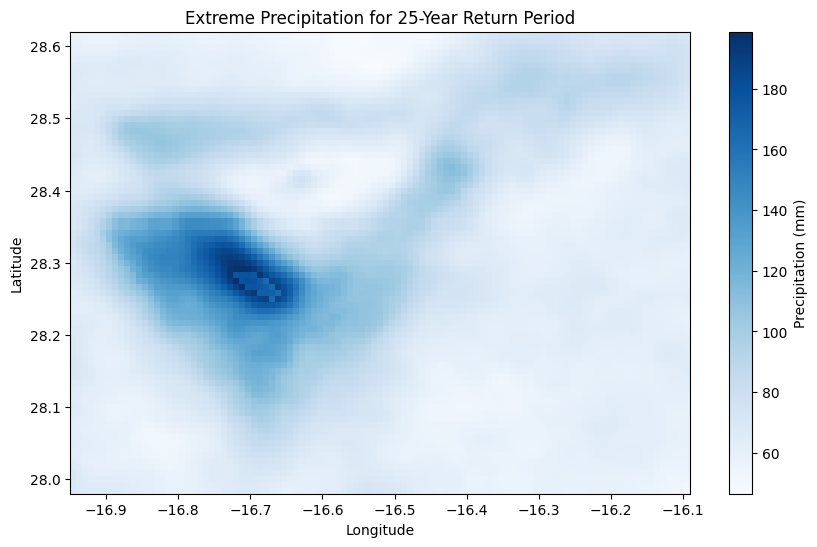

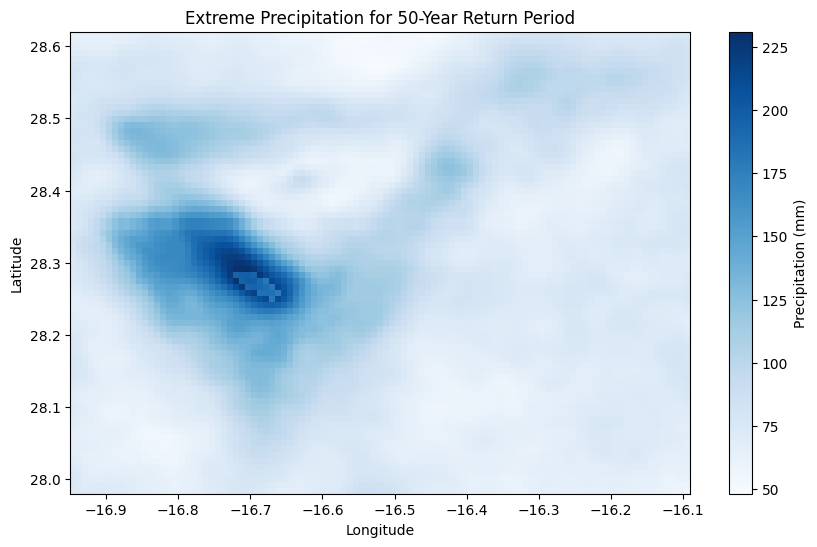

In [45]:
# Plotting the map of expected extreme precipitation of a given return period (RP)

# Befor plotting and saving as 2D map we have to select a quatile - other wise it is a 3D data cube

# Plot mean annual probability precipitation events > threshold
# Iterate over all return periods
for i, tau in enumerate(return_periods):
    selected_quantile = quantiles.isel(quantile=i)  # Extract 2D data for the current return period
    if isinstance(selected_quantile, xr.Dataset):
        selected_quantile = selected_quantile.to_array().isel(variable=0)  # Convert to DataArra
    # Create a figure for each return period
    plt.figure(figsize=(10, 6))
    selected_quantile.plot(cmap="Blues", cbar_kwargs={"label": "Precipitation (mm)"})
    plt.title(f"Extreme Precipitation for {tau}-Year Return Period")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Show the plot
    plt.show()


In [48]:
# Save map as netcdf files
 # Define output filename
# Iterate over all return periods and save each as a NetCDF file
for i, tau in enumerate(return_periods):
    selected_quantile = quantiles.isel(quantile=i)  # Extract 2D data for return period

    # Ensure it is a DataArray (not a Dataset)
    if isinstance(selected_quantile, xr.Dataset):
        selected_quantile = selected_quantile.to_array().isel(variable=0)

    # Define output filename
    filename = f"extreme_precipitation_{tau}yr.nc"

    # Save as NetCDF
    selected_quantile.to_netcdf(filename)
    print(f"Saved: {filename}")


Saved: extreme_precipitation_5yr.nc
Saved: extreme_precipitation_15yr.nc
Saved: extreme_precipitation_25yr.nc
Saved: extreme_precipitation_50yr.nc


In [ ]:
# Plotting the map of expected extreme precipitation of a given return period (RP)

# Befor plotting and saving as 2D map we have to select a quatile - other wise it is a 3D data cube
idx_q_sel = 0
pq2d = pq.sel(quantile=pq['quantile'][idx_q_sel], drop=True)

# Plot mean annual probability precipitation events > threshold
pq2d['tp'].plot.imshow()
plt.title('Extreme Precipitation Event RP: ' + str(return_period[idx_q_sel]) + 'yr')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()